In [1]:
#Importing Libraries
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

from sklearn.model_selection import train_test_split
import tensorflow as tf

In [41]:
#converting this to path object allows us to search inside the directory
image_dir = Path('archive/Fish_Dataset/Fish_Dataset')

In [42]:
# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Drop GT images
image_df['Label'] = image_df['Label'].apply(lambda x: np.NaN if x[-2:] == 'GT' else x)
image_df = image_df.dropna(axis=0)

#NOT gonna sample as I want higher accuracy

In [43]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

## Loading the Images

In [44]:
#Using ImageDataGenerator from keras
#we don't have to load all the files at the same time
#Using generator we only load in one batch at a time, train on the batch and then recycle the memory

#We are gonna use a pre trained model MobileNet
#Because of its extensive training, ImageNet has become extremely good at extracting information from any image
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input, #we have to make sure that we use the preprocessing function that comes along with mobilenet
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

#We are not loading in the images but rather just specifying how the imahes should be loaded

In [45]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224), #MobileNet was trained on (224,224)
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224), #MobileNet was trained on (224,224)
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224), #MobileNet was trained on (224,224)
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 5040 validated image filenames belonging to 9 classes.
Found 1260 validated image filenames belonging to 9 classes.
Found 2700 validated image filenames belonging to 9 classes.


In [7]:
#TODO: search about MobileNet and how it works with different architectures
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3), #this was the shape it was originally trained on (we will keep it that way)
    include_top=False, #this means to include original output layer for ImageNet dataset (we are keeping it false as we want to make our own predictions)
    weights='imagenet',
    pooling='avg' #this will ensure that the output is a 1D vector
)
pretrained_model.trainable = False #we are not gonna train the exisiting weights and rather use them as is

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-03-24 17:26:43.820650: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-24 17:26:43.820838: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
pretrained_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [9]:
train_images.next()[1] #each label is encoded as vector

array([[0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0.

In [10]:
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

In [11]:
inputs = pretrained_model.input

#passing the output of pretrained model to Dense layer to perform classification
x = Dense(128, activation='relu')(pretrained_model.output)
#passing output of previous dense layer to next one
x = Dense(128, activation='relu')(x)
#Finally doing classification
outputs = Dense(9, activation='softmax')(x)


model = tf.keras.Model(inputs=inputs, outputs=outputs)


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', #as the labels are vectors and not integers
    metrics=['accuracy']
)

#create callback
filepath = 'best_fish_model.h5'

# filepath = 'my_best_model.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                            monitor='val_loss',
                            verbose=1, 
                            save_best_only=True,
                            mode='min')
earlyStopping = EarlyStopping(monitor='val_loss', patience=3, verbose=0, restore_best_weights=True)
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')
callbacks = [checkpoint,earlyStopping,reduce_lr_loss]


history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50


2022-03-24 17:27:06.966784: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-24 17:27:08.888488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


158/158 [==============================] - ETA: 0s - loss: 0.2104 - accuracy: 0.9431

2022-03-24 17:28:22.409906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.02781, saving model to best_fish_model.h5
158/158 [==============================] - 94s 568ms/step - loss: 0.2104 - accuracy: 0.9431 - val_loss: 0.0278 - val_accuracy: 0.9921 - lr: 0.0010
Epoch 2/50
158/158 [==============================] - ETA: 0s - loss: 0.0178 - accuracy: 0.9956
Epoch 2: val_loss did not improve from 0.02781
158/158 [==============================] - 91s 572ms/step - loss: 0.0178 - accuracy: 0.9956 - val_loss: 0.0314 - val_accuracy: 0.9897 - lr: 0.0010
Epoch 3/50
158/158 [==============================] - ETA: 0s - loss: 0.0096 - accuracy: 0.9974
Epoch 3: val_loss improved from 0.02781 to 0.00816, saving model to best_fish_model.h5
158/158 [==============================] - 88s 556ms/step - loss: 0.0096 - accuracy: 0.9974 - val_loss: 0.0082 - val_accuracy: 0.9968 - lr: 0.0010
Epoch 4/50
158/158 [==============================] - ETA: 0s - loss: 0.0015 - accuracy: 0.9998
Epoch 4: val_loss did not improve from 0.00816
158/15

In [12]:
ldict = train_images.class_indices
label_dict = {v: k for k, v in ldict.items()}
label_dict

{0: 'Black Sea Sprat',
 1: 'Gilt-Head Bream',
 2: 'Hourse Mackerel',
 3: 'Red Mullet',
 4: 'Red Sea Bream',
 5: 'Sea Bass',
 6: 'Shrimp',
 7: 'Striped Red Mullet',
 8: 'Trout'}

In [13]:
b1 = test_images.next()[1]
labels = [(label_dict[list(x).index(1)],list(x)) for x in b1]
labels

[('Black Sea Sprat', [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
 ('Gilt-Head Bream', [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
 ('Black Sea Sprat', [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
 ('Trout', [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]),
 ('Red Mullet', [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
 ('Gilt-Head Bream', [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
 ('Striped Red Mullet', [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]),
 ('Red Mullet', [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
 ('Black Sea Sprat', [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
 ('Trout', [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]),
 ('Sea Bass', [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]),
 ('Gilt-Head Bream', [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
 ('Hourse Mackerel', [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
 ('Striped Red Mullet', [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]),
 ('Hourse Mackerel', [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [14]:
fmodel = tf.keras.models.load_model('best_fish_model.h5')

In [15]:
results = fmodel.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

2022-03-24 17:58:27.973916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


    Test Loss: 0.00177
Test Accuracy: 99.96%


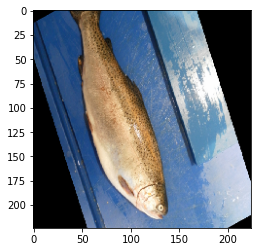

In [19]:
from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt
FileName = 'test images/Trout.png'

img = image.load_img(FileName,target_size=(224,224))

plt.imshow(img)

In [22]:
import cv2 as cv

In [48]:
test_images.next()[0].shape

(32, 224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Trout


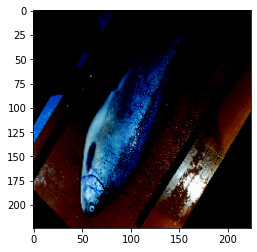

In [66]:
ti = test_images.next()
for x,y in zip(ti[0],ti[1]):
    # img = cv.imread(x[0])
    # cv.imshow('Test Image',x[0])
    rgb_img = cv.cvtColor(x, cv.COLOR_BGR2RGB)
    plt.imshow(rgb_img)
    print(label_dict[list(y).index(1)])
    break